# Miller OP

In this notebook the circuit shown in the following schematic will be sized to acheive a certain performance.

![Miller Operational Amplifier](./fig/moa.png)

Unlike `sym_sizing.ipynb` though, here the performance is obtained directly from the **simulator**, instead
of approxmiating it with

$$ A_{0} = - \frac{g_{\mathrm{m},\mathtt{ND12}}}{ g_{\mathrm{ds},\mathtt{ND12}} + g_{\mathrm{ds},\mathtt{PCM22}}} 
       \cdot \frac{g_{\mathrm{m},\mathtt{PCS}}}{ g_{\mathrm{ds},\mathtt{PCS}} + g_{\mathrm{ds},\mathtt{NCM13}}} $$

In [1]:
%matplotlib inline

In [2]:
import os
import torch
import numpy as np
import torch as pt
import pandas as pd
import joblib as jl
from functools import partial 
from scipy.interpolate import pchip_interpolate, interp1d
from scipy.optimize import minimize
from scipy.stats import norm
from skopt import gp_minimize
from sklearn.preprocessing import MinMaxScaler, minmax_scale
from matplotlib import pyplot as plt

## Specification

The following values are considered a priori knowledge.

| Parameter             | Specification |
|-----------------------|--------------:|
| $V_{\mathrm{DD}}$     |      $1.2\,V$ |
| $V_{\mathrm{SS}}$     |      $0.0\,V$ |
| $V_{\mathrm{in,cm}}$  |      $0.6\,V$ |
| $V_{\mathrm{out,cm}}$ |      $0.6\,V$ |
| $I_{\mathtt{B0}}$     |   $10\,\mu A$ |
| $C_{\mathrm{L}}$      |     $10\,p F$ |
| $C_{\mathrm{c}}$      |      $3\,p F$ |

In [3]:
V_DD  = 1.2
V_SS  = 0.0
V_ICM = 0.6
V_OCM = 0.6
I_B0  = 10e-6
C_L   = 10e-12
C_C   = 3e-12

## Simulator Setup

For evaluating the performance, the circuit is simulated with [PySpice](https://pyspice.fabrice-salvaire.fr/).

In [4]:
import logging
from PySpice.Spice.Netlist import Circuit, SubCircuitFactory
from PySpice.Spice.Library import SpiceLibrary
from PySpice.Unit import *

### DUT

The Millor Operational Amplifiere shown in the figure above is implemented as a `subckt`.

In [5]:
class MOA(SubCircuitFactory):
    NAME = "miller"
    NODES = (10, 11, 12, 13, 14, 15) # REF, INP, INN, OUT, GND, VDD
    
    def __init__(self):
        super().__init__()
        # Biasing Current Mirror
        self.MOSFET("NCM11" , 10, 10, 14, 14, model = "nmos")
        self.MOSFET("NCM12" , 16, 10, 14, 14, model = "nmos")
        
        # Differential Pair
        self.MOSFET("ND11"  , 17, 11, 16, 14, model = "nmos")
        self.MOSFET("ND12"  , 18, 12, 16, 14, model = "nmos")
        
        # PMOS Current Mirrors
        self.MOSFET("PCM21" , 17, 17, 15, 15, model = "pmos")
        self.MOSFET("PCM22" , 18, 17, 15, 15, model = "pmos")
        
        # Output Stage
        self.MOSFET("PCS"   , 13, 18, 15, 15, model = "pmos")
        self.MOSFET("NCM13" , 13, 10, 14, 14, model = "nmos")
        
        # Compensation
        self.C("c", 18, 13, C_C@u_F)

**Note**: for other technologies, the corresponding library has to included.

In [6]:
spice_library = SpiceLibrary("../lib/90nm_bulk.lib")
netlist = Circuit("moa_tb")
netlist.include(spice_library["nmos"])
netlist.subcircuit(MOA())

### Testbench

An AC-Testbench is setup to analyse the gain, this has to be adjusted for which ever target parameters are of interest.

In [7]:
netlist.X("moa", "miller", "B", "P", "N", "O", 0, "D")
moa   = list(netlist.subcircuits)[0]
i_ref = netlist.CurrentSource("ref",  0 , "B", I_B0@u_A)
v_dd  = netlist.VoltageSource("dd" , "D",  0 , V_DD@u_V)
v_in  = netlist.VoltageSource("in" , "N",  0 , V_ICM@u_V)
v_ip  = netlist.SinusoidalVoltageSource( "ip", "P", "E"
                                        , dc_offset=0.0@u_V
                                        , ac_magnitude=-1.0@u_V
                                        , )
e_buf = netlist.VoltageControlledVoltageSource("in", "E", 0, "O", 0, 1.0@u_V)
c_l   = netlist.C("L", "O", 0, C_L@u_F)

### Simulation

The `simulate` function takes a data frame with sizing parameters `W` and `L` as columns and each device in the ciruit as row index.
After modiying the corresponding model paramters within the `miller` sub circuit, the previously defined testbench is simulated.
Frequency, Gain and Phase vectors are returned for further processing. Additionallly, the Simulated netlist is returned.

In [8]:
def simulate(sizing_data):
    for device in sizing_data.index:
        moa.element(device).width  = sizing_data.loc[device].W
        moa.element(device).length = sizing_data.loc[device].L
    
    simulator = netlist.simulator( simulator="ngspice-subprocess"
                                 , temperature=27
                                 , nominal_temperature=27
                                 , )

    logging.disable(logging.FATAL)
    ac_analysis  = simulator.ac( start_frequency  = 1.0@u_Hz
                               , stop_frequency   = 1e11@u_Hz
                               , number_of_points = 10
                               , variation        = "dec"
                               , )
    
    freq  = np.array(ac_analysis.frequency)
    gain  = ((20 * np.log10(np.absolute(ac_analysis["O"]))) - (20 * np.log10(np.absolute(ac_analysis["P"]))))
    phase = np.angle(ac_analysis["O"], deg=True) - np.angle(ac_analysis["N"], deg=True)
    logging.disable(logging.NOTSET)
    
    return (freq, gain, phase, simulator)

With the gain and phase obtained from the AC simulation, the DC-gain, cutoff frequency as well as gain- and phase-margin can be determiend in the `performance` function.

In [9]:
def performance(freq, gain, phase):
    gf = [gain[np.argsort(gain)], freq[np.argsort(gain)]]
    pf = [phase[np.argsort(phase)], freq[np.argsort(phase)]]
    
    A0dB = pchip_interpolate(freq, gain, [1.0])
    A3dB = A0dB - 3.0
    f3dB = pchip_interpolate(*gf, [A3dB])
    
    fug = pchip_interpolate(*gf, [0.0]) if A0dB > 0 else np.ones(1)
    fp0 = pchip_interpolate(*pf, [0.0])
    
    PM = pchip_interpolate(freq, phase, [fug]) if A0dB > 0 else np.zeros(1)
    GM = pchip_interpolate(freq, gain, [fp0])
    
    performances = { "A0dB" : A0dB.item() 
                   , "f3dB" : f3dB.item()
                   , "fug"  : fug.item()
                   , "PM"   : PM.item()
                   , "GM"   : GM.item()
                   , }
    
    return performances

## Model Setup

A class `PrimitiveDevices` is instantiated for each model type (nmos, pmos). Each object provides a `predict` 
function that evaluates the corresponding model and scales inputs and outputs correspondingly.

In [10]:
class PrimitiveDevice():
    def __init__(self, prefix, params_x, params_y):
        self.prefix   = prefix
        self.params_x = params_x
        self.params_y = params_y
        
        self.model = pt.jit.load(f"{self.prefix}/model.pt")
        self.model.cpu()
        self.model.eval()
        
        self.scale_x = jl.load(f"{self.prefix}/scale.X")
        self.scale_y = jl.load(f"{self.prefix}/scale.Y")
        
    def predict(self, X):
        with pt.no_grad():
            X.fug = np.log10(X.fug.values)
            X_ = self.scale_x.transform(X[params_x].values)
            Y_ = self.model(pt.from_numpy(np.float32(X_))).numpy()
            Y  = pd.DataFrame( self.scale_y.inverse_transform(Y_)
                             , columns=params_y )
            Y.jd   = np.power(10, Y.jd.values)
            Y.gdsw = np.power(10, Y.gdsw.values)
        return pd.DataFrame(Y, columns=self.params_y)

In [11]:
devices           = [ "MNCM11", "MNCM12", "MNCM13" , "MND11", "MND12"
                    , "MPCM21", "MPCM22", "MPCS" ]
reference_devices = [ "MNCM12", "MNCM13", "MND12", "MPCM22", "MPCS" ]

The inputs and outputs of the model, trained in `model_training.ipynb` have to specified again.

In [12]:
params_x = ["gmid", "fug", "Vds", "Vbs"]
params_y = ["jd", "L", "gdsw", "Vgs"]

Initially the symmetrical amplifier is sized with the models for the $90\,\mathrm{nm}$ technology. 
Later this can be changed to any other technology model, yielding similar results.

In [13]:
nmos = PrimitiveDevice("../models/example/90nm-nmos", params_x, params_y)
pmos = PrimitiveDevice("../models/example/90nm-pmos", params_x, params_y)

## Sizing Procedure

![Symmetrical Amplifier](./fig/moa.png)

For simplicity in this example, only the $\frac{g_{\mathrm{m}}}{I_{\mathrm{d}}}$ dependend models
are considered. Therefore, sizing for all devices is expressed in terms of 
$\frac{g_{\mathrm{m}}}{I_{\mathrm{d}}}$ and $f_{\mathrm{ug}}$.

$$\gamma_{\mathrm{n,p}} \left ( \left [ \frac{g_{\mathrm{m}}}{I_{\mathrm{d}}}, f_{\mathrm{ug}}, V_{\mathrm{ds}}, V_{\mathrm{bs}} \right ]^{\dagger} \right ) 
\Rightarrow \left [ L, \frac{I_{\mathrm{d}}}{W}, \frac{g_{\mathrm{ds}}}{W}, V_{\mathrm{gs}} \right ]^{\dagger}
$$

First, the specification, given in the table above is considered,
from which a biasing current ${I_{\mathtt{B1}} = \frac{I_{\mathrm{B0}}}{2}}$ is defined.
This, in turn results in a mirror ratio $M_{\mathrm{n}} = 1 : 1$ of the NMOS current mirror `NCM1`.
The remaining branch current $I_{\mathtt{B2}} = M_{\mathrm{p}} \cdot \frac{I_{\mathtt{B2}}}{2}$ is determined as well.

In [14]:
M_N1  = 1
M_N2  = 1
I_B1 = I_B0 * M_N1
I_B2 = I_B0 * M_N2

Since the common mode output voltage $V_{\mathrm{out,cm}} = 0.6$ is known, 
the sizing procedure starts with the output stage `MPCS` and `MNCM13`:

$$ \gamma_{\mathrm{p}, \mathtt{MPCS}} \left ( \left [ \left ( \frac{g_{\mathrm{m}}}{I_{\mathrm{d}}} \right )_{\mathtt{MPCS}}
                                                    , f_{\mathrm{ug}, \mathtt{MPCS}}, (V_{\mathrm{DD}} - V_{\mathrm{out,cm}})
                                                    , 0.0 \right ]^{\dagger} 
                                     \right ) $$

$$ \gamma_{\mathrm{n}, \mathtt{MNCM13}} \left ( \left [ \left ( \frac{g_{\mathrm{m}}}{I_{\mathrm{d}}} \right )_{\mathtt{MNCM13}}
                                                      , f_{\mathrm{ug}, \mathtt{MNCM13}}, V_{\mathrm{out,cm}}, 0.0 \right ]^{\dagger} 
                                       \right ) $$

The gate voltage $V_{\mathrm{gs}, \mathtt{MPCS}}$ helps guiding the sizing for the differential pair, 
as well as the PMOS Current Mirror `MPCM2`, which is considered first:

$$ \gamma_{\mathrm{p}, \mathtt{MPCM22}} \left ( \left [ \left ( \frac{g_{\mathrm{m}}}{I_{\mathrm{d}}} \right )_{\mathtt{MPCM22}}
                                                      , f_{\mathrm{ug}, \mathtt{MPCM22}}
                                                      , (V_{\mathrm{DD}} -  V_{\mathrm{gs}, \mathtt{MPCS}})
                                                      , 0.0 \right ]^{\dagger} 
                                       \right ) $$

Sizing the differential pair requires, _guessing_ $V_{\mathrm{x}} = 0.23\,\mathrm{V}$ which is done by considering 
the fact that 3 devices are stacked and `MNCM1` merely serves as biasing. Therefore:

$$ \gamma_{\mathrm{n}, \mathtt{MND12}} \left ( \left [ \left ( \frac{g_{\mathrm{m}}}{I_{\mathrm{d}}} \right )_{\mathtt{MND12}}
                                                      , f_{\mathrm{ug}, \mathtt{MND12}}
                                                      , (V_{\mathrm{DD}} -  V_{\mathrm{gs}, \mathtt{MPCS}} - V_{\mathrm{x}})
                                                      , - V_{\mathrm{x}} \right ]^{\dagger} 
                                      \right ) $$

Subsequently, the biasing current mirror `MNCM1` is sized:

$$ \gamma_{\mathrm{n}, \mathtt{MNCM12}} \left ( \left [ \left ( \frac{g_{\mathrm{m}}}{I_{\mathrm{d}}} \right )_{\mathtt{MNCM12}}
                                                      , f_{\mathrm{ug}, \mathtt{MNCM12}}
                                                      , V_{\mathrm{x}}
                                                      , 0.0 \right ]^{\dagger} 
                       \right ) $$

With these five function calls, the sizing of the entire circuit is expressed in terms of eight electrical characteristics.
The following function `miller_sizing` takes a `dict` with keys for each _reference device_ $\in$ 
`reference_devices = [ "MNCM12", "MNCM13", "MND12", "MPCM22", "MPCS" ]` and corresponding, desired characteristics. 
The obtained sizing for each device is propageted to related devices in the same building block and a new `dict` with sizing information is returned.

In [15]:
def miller_sizing( gmid_pcs, gmid_ncm13, gmid_pcm22, gmid_nd12, gmid_ncm12
                 , fug_pcs,  fug_ncm13,  fug_pcm22,  fug_nd12,  fug_ncm12 ):
    
    ec                 = {}
    
    ## Common Source Output Stage
    input_pcs          = pd.DataFrame( np.array([[gmid_pcs, fug_pcs, (V_DD - V_OCM), 0.0]])
                                     , columns=params_x )
    ec["MPCS"]         = pmos.predict(input_pcs).join(input_pcs)
    ec["MPCS"]["W"]    = I_B2 / ec["MPCS"].jd
    
    ## NMOS Output Stage
    input_ncm13        = pd.DataFrame( np.array([[gmid_ncm13, fug_ncm13, V_OCM, 0.0]])
                                     , columns=params_x )
    ec["MNCM13"]       = nmos.predict(input_ncm13).join(input_ncm13)
    ec["MNCM13"]["W"]  = I_B2 / ec["MNCM13"].jd
    #ec["MNCM12"]       = ec["MNCM13"].copy()     
    #ec["MNCM11"]       = ec["MNCM13"].copy()     
    #ec["MNCM12"].W     = ec["MNCM13"].W / M_N2
    #ec["MNCM11"].W     = ec["MNCM13"].W / M_N1
    
    ## PMOS Current Mirror MPCM2:
    V_GS               = ec["MPCS"].Vgs.values[0]
    input_pcm22        = pd.DataFrame( np.array([[ gmid_pcm22, fug_pcm22, (V_DD - V_GS), 0.0]])
                                     , columns=params_x )
    ec["MPCM22"]       = pmos.predict(input_pcm22).join(input_pcm22)
    ec["MPCM22"]["W"]  = (I_B1 / 2) / ec["MPCM22"].jd     
    ec["MPCM21"]       = ec["MPCM22"]
   
    ## NMOS Differential Pair NDP1:
    V_X                = 0.23
    input_nd12         = pd.DataFrame( np.array([[gmid_nd12, fug_nd12, (V_DD - V_GS - V_X), -V_X]])
                                     , columns=params_x )
    ec["MND12"]        = nmos.predict(input_nd12).join(input_nd12)
    ec["MND12"]["W"]   = (I_B1 / 2) / ec["MND12"].jd
    ec["MND11"]        = ec["MND12"]
    
    ## NMOS Current Mirror NCM12:
    input_ncm12        = pd.DataFrame( np.array([[gmid_ncm12, fug_ncm12, V_X, 0.0]])
                                     , columns=params_x )
    ec["MNCM12"]       = nmos.predict(input_ncm12).join(input_ncm12)
    ec["MNCM12"]["W"]  = I_B1 / ec["MNCM12"].jd
    ec["MNCM11"]       = ec["MNCM12"].copy()
    ec["MNCM11"].W     = ec["MNCM11"].W * M_N1
    
    ## Calculate/Approximate Operating point Parameters
    for dev,val in ec.items():
        val["gds"] = val.gdsw * val.W
        val["id"]  = val.jd * val.W
        val["gm"]  = val.gmid * val.id
    
    return ec

The operating points for each device are approximated for given electrical characteristics of each _reference device_ in the circuit.

In [16]:
def miller_op_approx( gmid_pcs, gmid_ncm13, gmid_pcm22, gmid_nd12, gmid_ncm12
                    , fug_pcs,  fug_ncm13,  fug_pcm22,  fug_nd12,  fug_ncm12 ):
    sizing = miller_sizing( gmid_pcs, gmid_ncm13, gmid_pcm22, gmid_nd12, gmid_ncm12
                          , fug_pcs,  fug_ncm13,  fug_pcm22,  fug_nd12,  fug_ncm12 )
    sizing_data = pd.concat(sizing.values(), names=sizing.keys())
    sizing_data.index = sizing.keys()
    return sizing_data

The objective function for reaching a certain gain is formulated, such that it only depends on the individual $f_{\mathrm{ug}}$s of the reference devices.
This limits the search space by halfing the number of variables in the optimization problem, while keeping it portable across technologies, 
since $\frac{g_{\mathrm{m}}}{I_{\mathrm{d}}}$, unlike the speed, stays the same.

$$ \underset{f_{\mathrm{ug,moa}}}{\arg\min} ~ | A_{0,\mathrm{moa}} - A_{0, \mathrm{target}} | $$

Where 

$$ f_{\mathrm{ug,moa}} = 
    \left[ f_{\mathrm{ug},\mathtt{NDP12}} 
         , f_{\mathrm{ug},\mathtt{NCM12}}  
         , f_{\mathrm{ug},\mathtt{PCS}}  
         , f_{\mathrm{ug},\mathtt{NCM13}}  
         , f_{\mathrm{ug},\mathtt{PCM22}}  
      \right]^{\dagger} $$

In [17]:
gmid_pcs_fix   = 10.0
gmid_ncm12_fix = 5.0
gmid_ncm13_fix = 10.0
gmid_pcm22_fix = 10.0
gmid_nd12_fix  = 12.0

fug_pcs_prd    = np.nan
fug_ncm13_prd  = np.nan
fug_pcm22_prd  = np.nan
fug_nd12_prd   = np.nan
fug_ncm12_prd  = np.nan

Specify desired target i.e. $A_{0,\mathrm{target}}$ and maximum number of simulations `sim_budget`.

In [18]:
A0dB_target = 88

Since it's an optimization (minimization) problem, the negative gain $- A_{0,\mathrm{moa}}$ is returned.

In [19]:
def miller_gain_target( gmid_pcs, gmid_ncm13, gmid_pcm22, gmid_nd12, gmid_ncm12
                      , fug_pcs,  fug_ncm13,  fug_pcm22,  fug_nd12,  fug_ncm12 ):
    fug = map( lambda f: np.power(10, f)
             , [fug_pcs, fug_ncm13, fug_pcm22, fug_nd12, fug_ncm12] )
    apop = miller_op_approx(gmid_pcs, gmid_ncm13, gmid_pcm22, gmid_nd12, gmid_ncm12, *fug)
    freq, gain, phase, _ = simulate(apop)
    perf = performance(freq, gain, phase)
    #return -perf["A0dB"]
    return np.abs(A0dB_target - perf["A0dB"])

Apply fixed parameters, to reduce the search space:

In [20]:
miller_target = partial( miller_gain_target
                       , gmid_pcs_fix, gmid_ncm13_fix
                       , gmid_pcm22_fix, gmid_nd12_fix 
                       , gmid_ncm12_fix )

Subsequently a bayesian surrogate model for the gain of the entire circuit is created.

In [21]:
miller_gp = gp_minimize( lambda f: miller_target(*f)      # Gain Target Function 
                       , [ (6.0, 11.0)                    # Bounds: log10(fug_ncm12)
                         , (6.0, 11.0)                    # Bounds: log10(fug_pcs)
                         , (6.0, 11.0)                    # Bounds: log10(fug_ncm12)
                         , (6.0, 11.0)                    # Bounds: log10(fug_ncm13)
                         , (6.0, 11.0) ]                  # Bounds: log10(fug_pcm12)
                       , acq_func        = "PI"           # EI, PI, LCB
                       , n_calls         = 20             # Maximum number of simulations
                       , n_random_starts = 7              # Number of random init points
                       , noise           = 1e-3           # Prediction Noise (Uncertainty)
                       , random_state    = 666            # RNG seed
                       , n_jobs          = os.cpu_count() # Number of Cores
                       , )

In [22]:
_, std_moa  = miller_gp.models[-1].predict(miller_gp.space.transform([miller_gp.x]), return_std=True)
σ_moa       = std_moa[0]
μ_moa       = (A0dB_target - miller_gp.fun)
miller_dist = norm.pdf(np.arange(60,100,0.01), μ_moa, σ_moa)

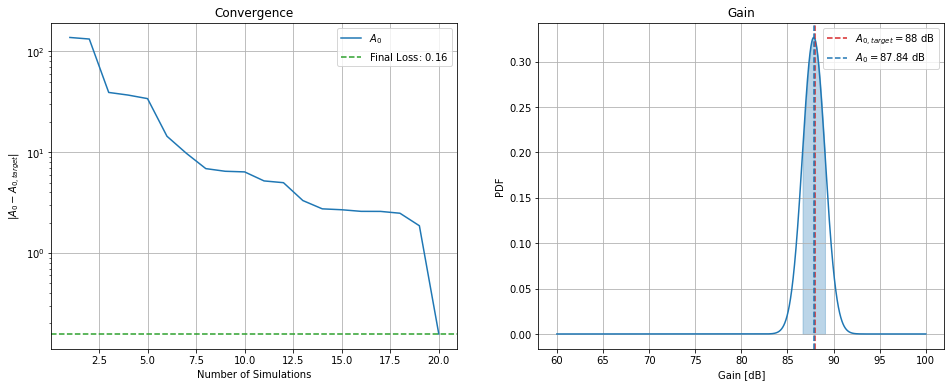

In [23]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16,6))
ax1.plot( np.array(list(range(miller_gp.func_vals.size))) + 1
        , np.sort(miller_gp.func_vals)[::-1]
        , label=f"$A_{{0}}$"
        , )
ax1.axhline( y=miller_gp.fun
           , ls="dashed"
           , color="tab:green"
           , label=f"Final Loss: ${miller_gp.fun:.2f}$"
           , )
ax1.set_ylabel(f"$| A_{{0}} - A_{{0,target}} |$")
ax1.set_xlabel("Number of Simulations")
ax1.set_title("Convergence")
ax1.set_yscale("log")
ax1.legend()
ax1.grid("on")


gain_range = np.arange(60,100,0.01)
ax2.plot(gain_range, miller_dist)
ax2.axvline( x=A0dB_target
           , ls="dashed"
           , color="tab:red"
           , label=f"$A_{{0,target}} = {A0dB_target}$ dB"
           , )
ax2.axvline( x=np.abs(A0dB_target - miller_gp.fun)
           , ls="dashed"
           , color="tab:blue"
           , label=f"$A_{{0}} = {np.abs(A0dB_target - miller_gp.fun):.2f}$ dB"
           , )
px = gain_range[np.logical_and( gain_range >= (μ_moa - σ_moa * 3)
                              , gain_range <= (μ_moa + σ_moa * 3))]
plt.fill_between( gain_range,miller_dist
                , where = (gain_range >= (μ_moa - σ_moa)) 
                        & (gain_range <= (μ_moa + σ_moa))
                , color='tab:blue'
                , alpha=0.3
                , )
ax2.set_ylabel(f"PDF")
ax2.set_xlabel("Gain [dB]")
ax2.set_title("Gain")
ax2.legend()
ax2.grid("on")

Retrieve the best Bayesian Model:

Retrieve the function arguments, minimizing the target:

In [24]:
fug_pcs_prd, fug_ncm13_prd, fug_pcm22_prd, fug_nd12_prd, fug_ncm12_prd = np.power(10, miller_gp.x)

## Evaluation

Finally, the obtianed characteristics are simulated one more time to verify the performance.

In [25]:
apop = miller_op_approx( gmid_pcs_fix, gmid_ncm13_fix, gmid_pcm22_fix, gmid_nd12_fix, gmid_ncm12_fix
                       , fug_pcs_prd,  fug_ncm13_prd,  fug_pcm22_prd,  fug_nd12_prd,  fug_ncm12_prd )
freq, gain, phase, _ = simulate(apop)
perf = performance(freq, gain, phase)

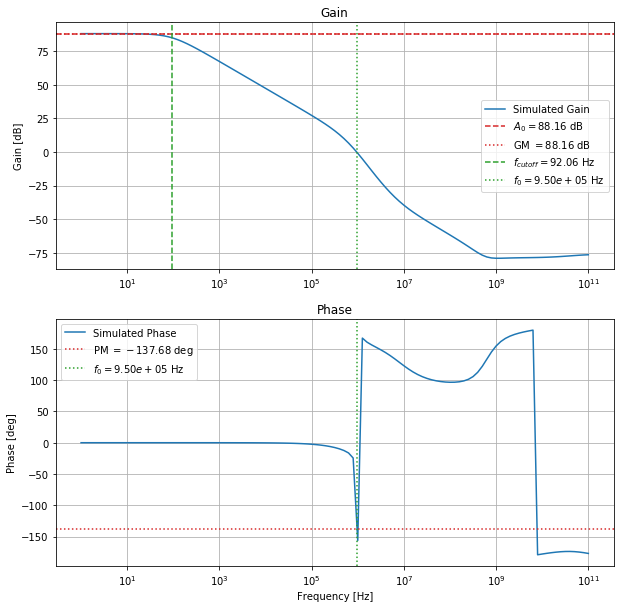

In [26]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10,10))
ax1.plot(freq, gain, label="Simulated Gain")
ax1.axhline( y=perf["A0dB"]
           , color="tab:red"
           , ls="dashed"
           , label=f"$A_{{0}} = {perf['A0dB']:.2f}$ dB")
ax1.axhline(y=perf["GM"]
           , color="tab:red"
           , ls="dotted"
           , label=f"GM $= {perf['GM']:.2f}$ dB")
ax1.axvline( x=perf["f3dB"]
           , color="tab:green"
           , ls="dashed"
           , label=f"$f_{{cutoff}} = {perf['f3dB']:.2f}$ Hz")
ax1.axvline( x=perf["fug"]
           , color="tab:green"
           , ls="dotted"
           , label=f"$f_{{0}} = {perf['fug']:.2e}$ Hz")
ax1.set_title("Gain")
ax1.set_xscale("log")
ax1.set_ylabel("Gain [dB]")
ax1.legend()
ax1.grid("on")

ax2.plot(freq, phase, label="Simulated Phase")
ax2.axhline( y=perf["PM"]
           , color="tab:red"
           , ls="dotted"
           , label=f"PM $= {perf['PM']:.2f}$ deg")
ax2.axvline( x=perf["fug"]
           , color="tab:green"
           , ls="dotted"
           , label=f"$f_{{0}} = {perf['fug']:.2e}$ Hz")
ax2.set_title("Phase")
ax2.set_xscale("log")
ax2.set_xlabel("Frequency [Hz]")
ax2.set_ylabel("Phase [deg]")
ax2.legend()
ax2.grid("on")

This performance is achieved with the following sizing:

In [27]:
apop.fug = np.power(10, apop.fug)
apop[["W", "L", "gmid", "fug"]]

,W,L,gmid,fug
MPCS,0.000064,0.000006,10.0,3.398350e+06
MNCM13,0.000025,0.000010,10.0,7.470581e+06
MPCM22,0.000070,0.000010,10.0,1.000000e+06
MPCM21,0.000070,0.000010,10.0,1.000000e+06
MND12,0.000001,0.000001,12.0,3.710863e+08
MND11,0.000001,0.000001,12.0,3.710863e+08
MNCM12,0.000002,0.000004,5.0,9.728755e+07
MNCM11,0.000002,0.000004,5.0,9.728755e+07
